In [1]:
from src.utils.logging_config import setup_logging
from data.weather_loader import fetch_weather_open_meteo, save_weather_to_csv

setup_logging()

lat = 54.77059160675461
lon = 9.309187447739384

df_hist, df_fc = fetch_weather_open_meteo(
    latitude=lat,
    longitude=lon,
    past_hours=24,
    forecast_hours=24,
)

save_weather_to_csv(
    df_hist,
    df_fc,
    hist_path="wetter_historisch_letzte24h_15min.csv",
    forecast_path="wetter_prognose_24h_15min.csv",
)


2025-12-03 19:12:14 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-03 19:12:14 [INFO] data.weather_loader - Hole Wetterdaten von Open-Meteo (lat=54.770592, lon=9.309187, past=24h, forecast=24h)
c:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code\fca_leistungsbaender\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-12-03 19:12:15 [INFO] data.weather_loader - 15-Minuten-Auflösung erkannt.
2025-12-03 19:12:15 [INFO] data.weather_loader - Anzahl historischer Punkte: 97
2025-12-03 19:12:15 [INFO] data.weather_loader - Anzahl Prognose-Punkte: 95
2025-12-03 19:12:15 [INFO] data.weather_loader - Historische Wetterdaten gespeichert nach wetter_historisch_letzte24h_15min.csv (Zeilen: 97)
2025-12-03 19

In [1]:
import logging

from data.data_loader import load_all_data
# falls du schon ein setup_logging hast:
# from src.utils.logging_config import setup_logging
# setup_logging()
logging.basicConfig(level=logging.INFO)

data = load_all_data(
    weather_past_hours=6,      # zum Testen klein halten
    weather_forecast_hours=6,
)

data.keys()


INFO:data.data_loader:Starte Laden der historischen Wirkleistungs- und Wetterdaten ...
INFO:data.data_loader:Lade Knotendaten (inkl. P_Datapoint_ID und Lat/Lon) aus data\raw\graph\whole_graph.json ...
INFO:data.data_loader:Knotendaten geladen: 16 Knoten.
INFO:data.data_loader:Verarbeite Node SHUW_E24 (DP=97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380) ...
ERROR:data.data_loader:Fehler beim Abruf für Node SHUW_E24: 401 Client Error: Unauthorized for url: https://api.iot.eon.com/datapoints/v1/97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380/samples:aggregate?interval.startTime=2024-01-01T00%3A00%3A00.000Z&interval.endTime=2025-12-03T18%3A56%3A01.000Z&timeBucket.factor=15&timeBucket.unit=MINUTE&timeBucket.timeZone=Europe%2FBerlin&aggregation=AVG
Traceback (most recent call last):
  File "c:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code\fca_leistungsbaender\data\data_loader.py", line 159, in load_all_data
    resp = fetch_datapoint_raw(
        datapoint_id=dp_id,
    ...<5 lines>...
        timezone_str=T

dict_keys(['nodes', 'measurements', 'weather_hist', 'weather_forecast'])

In [1]:
from src.data.eiot_client import _load_eiot_token
import logging

logging.getLogger("src.data.eiot_client").setLevel(logging.INFO)

try:
    token = _load_eiot_token()
    print("Token erfolgreich geladen. Länge:", len(token))
    print("Token (Anfang):", token[:50], "...")
except Exception as e:
    print("Fehler beim Laden des Tokens:", repr(e))


Token erfolgreich geladen. Länge: 1250
Token (Anfang): eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6InJ0c0 ...


In [2]:
from datetime import datetime, timezone, timedelta
from src.data.eiot_client import fetch_datapoint_raw

dp_id = "7b3fec1d-2c6f-4450-b41a-74d709e1c3b6"  # eine gültige ID einsetzen
start = datetime.now(timezone.utc) - timedelta(hours=1)
end = datetime.now(timezone.utc)

try:
    resp = fetch_datapoint_raw(
        datapoint_id=dp_id,
        start_time=start,
        end_time=end,
        aggregation="AVG",
        bucket_factor=15,
        bucket_unit="MINUTE",
        timezone_str="Europe/Berlin",
        chunk_days=1,
    )
    print("OK, Samples:", len(resp.get("samples", [])))
except Exception as e:
    print("Fehler beim EIOT-Request:", repr(e))


OK, Samples: 4


In [5]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from datetime import datetime, timezone
import logging
import pandas as pd

from src.data.data_loader import load_all_data

# Logging hochdrehen (optional)
logging.getLogger("src.data").setLevel(logging.INFO)
logging.getLogger("src.data.data_loader").setLevel(logging.INFO)
logging.getLogger("src.data.eiot_client").setLevel(logging.INFO)
logging.getLogger("src.data.weather_loader").setLevel(logging.INFO)

# --- Zeitraum für Wetter definieren: 01.01.2024 bis jetzt ---

tz = "Europe/Berlin"
now = pd.Timestamp.now(tz=tz)              # entspricht dem 'now' in fetch_weather_open_meteo
start_weather = pd.Timestamp("2024-01-01 00:00", tz=tz)

past_hours = int((now - start_weather).total_seconds() // 3600) + 1

print(f"Wetter-Historie: von {start_weather} bis {now}")
print(f"-> weather_past_hours = {past_hours}")

print("Starte Datenladen ...")

data = load_all_data(
    weather_forecast_hours=24,   # oder 0, wenn du keinen Forecast brauchst
)


print("FERTIG.\n")

print("Geladene Nodes:")
print(data["nodes"].index.tolist())

print("\nNodes mit Messwerten:")
print(list(data["measurements"].keys()))

if data["measurements"]:
    first = next(iter(data["measurements"].keys()))
    print("\nBeispiel für ersten Node:", first)
    print(data["measurements"][first].head())
    print(data["measurements"][first].tail())


Wetter-Historie: von 2024-01-01 00:00:00+01:00 bis 2025-12-10 12:45:03.237956+01:00
-> weather_past_hours = 17029
Starte Datenladen ...


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s_old, s_new])
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s_old, s_new])
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a 

FERTIG.

Geladene Nodes:
['SHUW_E24', 'SHUW_E23', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02', 'BOLN_E02', 'BOLN_E03', 'BOLN_E01', 'BOLS_E42', 'BOLS_E41']

Nodes mit Messwerten:
['SHUW_E24', 'SHUW_E23', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02', 'BOLN_E03', 'BOLN_E01', 'BOLS_E42', 'BOLS_E41', 'JUBO_E01', 'BOLN_E02']

Beispiel für ersten Node: SHUW_E24
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Name: P_MW, dtype: float64
2025-12-10 11:30:00   NaN
2025-12-10 11:45:00   NaN
2025-12-10 12:00:00   NaN
2025-12-10 12:15:00   NaN
2025-12-10 12:30:00   NaN
Name: P_MW, dtype: float64


### Test data cleaning

In [1]:
from src.data.data_loader import load_all_data
from src.data.data_cleaning import clean_data

# 1) Rohdaten laden
raw = load_all_data()

print(
    "Nodes:", len(raw["nodes"]),
    "| Messreihen:", len(raw["measurements"]),
    "| Wetter-Hist:", len(raw["weather_hist"]),
)

# 2) Bereinigung
clean = clean_data(raw)

print(
    "Clean-Messreihen:", len(clean["measurements"]),
    "| Clean-Wetter-Hist:", len(clean["weather_hist"]),
)


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'historical-forecast-api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made t

Nodes: 16 | Messreihen: 16 | Wetter-Hist: 16
Clean-Messreihen: 16 | Clean-Wetter-Hist: 16


In [3]:
# Einen beliebigen Node nehmen, der Messwerte hat
node_id = next(iter(raw["measurements"].keys()))
print("Teste Node:", node_id)

s_raw = raw["measurements"][node_id]
s_clean = clean["measurements"][node_id]

print("\nRAW P_MW head:")
print(s_raw.head())

print("\nCLEAN P_MW head:")
print(s_clean.head())

print("\nRAW Zeitspanne:", s_raw.index.min(), "→", s_raw.index.max())
print("CLEAN Zeitspanne:", s_clean.index.min(), "→", s_clean.index.max())

print("\nNaNs P_MW (raw → clean):",
      s_raw.isna().sum(), "→", s_clean.isna().sum())


Teste Node: SHUW_E24

RAW P_MW head:
timestamp
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Name: P_MW, dtype: float64

CLEAN P_MW head:
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Freq: 15min, Name: P_MW, dtype: float64

RAW Zeitspanne: 2024-01-01 00:00:00 → 2025-12-07 17:15:00
CLEAN Zeitspanne: 2024-01-01 00:00:00 → 2025-12-07 17:15:00

NaNs P_MW (raw → clean): 2364 → 2089


In [4]:
weather_cols = ["temperature_C", "wind_speed_mps", "solar_radiation_Wm2"]

if node_id in raw["weather_hist"]:
    w_raw = raw["weather_hist"][node_id]
    w_clean = clean["weather_hist"][node_id]

    print("\nRAW Wetter head:")
    print(w_raw[weather_cols].head())

    print("\nCLEAN Wetter head:")
    print(w_clean[weather_cols].head())

    print("\nNaNs Wetter (raw → clean):")
    for col in weather_cols:
        if col in w_raw.columns:
            print(
                col,
                ":", w_raw[col].isna().sum(),
                "→", w_clean[col].isna().sum()
            )
else:
    print("Keine Wetterdaten für Node", node_id)



RAW Wetter head:
                     temperature_C  wind_speed_mps  solar_radiation_Wm2
time                                                                   
2024-01-01 01:00:00            6.6            17.7                  0.0
2024-01-01 01:15:00            6.6            17.4                  0.0
2024-01-01 01:30:00            6.5            17.1                  0.0
2024-01-01 01:45:00            6.4            16.9                  0.0
2024-01-01 02:00:00            6.3            16.5                  0.0

CLEAN Wetter head:
                     temperature_C  wind_speed_mps  solar_radiation_Wm2
2024-01-01 01:00:00            6.6            17.7                  0.0
2024-01-01 01:15:00            6.6            17.4                  0.0
2024-01-01 01:30:00            6.5            17.1                  0.0
2024-01-01 01:45:00            6.4            16.9                  0.0
2024-01-01 02:00:00            6.3            16.5                  0.0

NaNs Wetter (raw → clean)

In [1]:
from src.main import main
print("go")
res = main(run_full_pipeline=False)

raw = res["raw"]
clean = res["clean"]

node_id = next(iter(raw["measurements"].keys()))
print("Node:", node_id)
print(clean["measurements"][node_id].head())


2025-12-07 21:00:19 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-07 21:00:19 [INFO] src.main - Starte Leistungsband-Service...


go


2025-12-07 21:00:24 [INFO] src.data.data_loader - Starte Laden der historischen Wirkleistungs- und Wetterdaten (global_start_local=2024-01-01 01:00:00+01:00, end_local=2025-12-07 21:00:24.540540+01:00, global_start_utc=2024-01-01 00:00:00+00:00, end_time_utc=2025-12-07 20:00:24.540540+00:00) ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Lade Knotendaten (inkl. P_Datapoint_ID, Lat/Lon, DerivedSpec) aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Knotendaten geladen: 16 Knoten.
2025-12-07 21:00:24 [INFO] src.data.data_loader - Verarbeite Node SHUW_E24 (DP=97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380) ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Gefundene bestehende Hist-Daten für SHUW_E24: von 2024-01-01 00:00:00 bis 2025-12-07 17:45:00 (Zeilen: 67848)
2025-12-07 21:00:24 [INFO] src.data.data_loader - Node SHUW_E24: vorhandene Daten bis 2025-12-07 17:45:00 (loc

Node: SHUW_E24
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Freq: 15min, Name: P_MW, dtype: float64


## Graph Stuff

In [7]:
# ================================================
# Test des Netzmodells & Konsistenzchecks
# ================================================

from src.network.network_model import load_network_model
from src.utils.logging_config import setup_logging

import numpy as np
import pandas as pd

setup_logging()

# ------------------------------------------------
# Netzmodell laden
# ------------------------------------------------
net = load_network_model()  # optional: load_network_model(slack_node="SHUW_E24")

print("---- Netzmodell Überblick ----")
print("Anzahl Knoten:", len(net.nodes))
print("Anzahl Leitungen:", len(net.lines))
print("Shape A (lines x nodes):", net.A.shape)
print("Shape Bbus (nodes x nodes):", net.Bbus.shape)
print("Slack-Knoten:", net.slack_node)
print("Shape Ar:", net.Ar.shape)
print("Shape B_rr:", net.B_rr.shape)

print("\n---- Beispiel: Nodes ----")
display(net.nodes.head())

print("\n---- Beispiel: Leitungen ----")
# Wir haben Limits nur in Ampere, keine MW-Limits und keine Längen mehr im Modell notwendig
cols_to_show = [c for c in ["from_node", "to_node", "x", "b", "limit_a"] if c in net.lines.columns]
display(net.lines[cols_to_show].head())


# ================================================
# Konsistenzcheck 1: Bbus Symmetrie
# ================================================
B = net.Bbus.values
print("\nSymmetriecheck Bbus:")
sym_diff = np.abs(B - B.T).max()
print("max |B - B^T| =", sym_diff)

# ================================================
# Konsistenzcheck 2: Spaltensummen von Bbus
# ================================================
col_sums = B.sum(axis=0)
print("max |Spaltensumme(Bbus)| =", np.abs(col_sums).max())

# ================================================
# Konsistenzcheck 3: Rang von B_rr
# ================================================
rank_B_rr = np.linalg.matrix_rank(net.B_rr.values)
print("Rang von B_rr:", rank_B_rr, "von", net.B_rr.shape[0])


# ================================================
# Konsistenzcheck 4: Reaktanzen – aber Busbar-Leitungen ausnehmen
# ================================================
print("\n---- Reaktanz-Check (nur Nicht-Busbar-Leitungen) ----")

# Debug: Welche Typen gibt es überhaupt?
if "type" in net.nodes.columns:
    print("Verfügbare Node-Typen und Häufigkeit:")
    print(net.nodes["type"].value_counts())
else:
    print("Warnung: net.nodes hat keine Spalte 'type'. Busbars können dann nicht erkannt werden.")
    
# Busbar-Knoten bestimmen (falls 'type' vorhanden)
if "type" in net.nodes.columns:
    # Annahme: Index von net.nodes ist die Node-ID (z.B. 'SHUW', 'SHUW_E24', ...)
    busbar_nodes = set(net.nodes.index[net.nodes["type"] == "busbar"])
else:
    busbar_nodes = set()

print("\nAnzahl erkannter Sammelschienen (busbar_nodes):", len(busbar_nodes))
if len(busbar_nodes) > 0:
    print("Beispiel Busbar-Nodes:", list(sorted(busbar_nodes))[:10])

# Falls 'x' nicht existiert, abbrechen
if "x" not in net.lines.columns:
    print("Spalte 'x' in net.lines nicht gefunden – kein Reaktanz-Check möglich.")
else:
    # 1) Leitungen mit fehlender oder 0-Reaktanz
    is_missing_x = net.lines["x"].isna() | (net.lines["x"] == 0)

    # 2) Leitungen, die an eine Sammelschiene angeschlossen sind:
    #    -> from_node ODER to_node ist in busbar_nodes
    if busbar_nodes:
        connected_to_busbar = (
            net.lines["from_node"].isin(busbar_nodes)
            | net.lines["to_node"].isin(busbar_nodes)
        )
    else:
        # Keine Busbars bekannt -> alle False
        connected_to_busbar = pd.Series(False, index=net.lines.index)

    # 3) Wirkliche Problem-Leitungen:
    #    fehlende/0 Reaktanz UND NICHT an Busbar angeschlossen
    problem_lines = net.lines[is_missing_x & ~connected_to_busbar]

    print(f"Gesamtzahl Leitungen mit fehlender/0 Reaktanz: {int(is_missing_x.sum())}")
    print(f"...davon direkt an Sammelschienen angeschlossen: {int((is_missing_x & connected_to_busbar).sum())}")
    print(f"...übrig (relevant zu prüfen): {len(problem_lines)}")

    if len(problem_lines) > 0:
        print("\nLeitungen mit fehlender/0 Reaktanz (ohne Busbar-Anschluss):")
        cols_show = [c for c in ["from_node", "to_node", "x", "limit_a"] if c in problem_lines.columns]
        display(problem_lines[cols_show].head(20))
    else:
        print("✅ Alle relevanten (Nicht-Busbar-)Leitungen haben eine gültige Reaktanz.")


print("\nNetzmodell-Test abgeschlossen.")


2025-12-08 12:32:40 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 12:32:40 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 12:32:40 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 12:32:40 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung TARP_SS_TARP_E01 (Tarp -> Tarp_E01) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung JUBO_E03_JUBO (JUBO -> JUBO_E03) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird

---- Netzmodell Überblick ----
Anzahl Knoten: 29
Anzahl Leitungen: 6
Shape A (lines x nodes): (6, 29)
Shape Bbus (nodes x nodes): (29, 29)
Slack-Knoten: BOLN_E01
Shape Ar: (6, 28)
Shape B_rr: (28, 28)

---- Beispiel: Nodes ----


,label,type,pos_x,pos_y,P_Datapoint_ID,Q_Datapoint_ID,Windgeschw_Datapoint,Globale_Strahlung_Datapoint,Aussentemp_Datapoint,Latitude_deg,Longitude_deg,Strom_Limit_in_A,DAB_ID,busbar_id,derived,p_max_MW
id,,,,,,,,,,,,,,,,
BOLN,BOLN,busbar,850.387134,0.010577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOLN_A3,BOLN_A3,junction,619.655071,-1.172015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOLN_E01,BOLN_E01,uw_field,990.284389,40.972400,34482f6c-cbbc-4f7f-99ae-db73a5885eb9,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,SHNG_E:DSO:SHN:ST:STUW45210:SA:110:SF:E01,NaN,NaN,NaN
BOLN_E02,BOLN_E02,uw_field,714.233866,-4.270225,NaN,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,NaN,"BOLN_E03:-1, BOLN_E02:-1","{'method': 'field_sum', 'feature_key': 'P', 't...",NaN
BOLN_E03,BOLN_E03,uw_field,984.103815,-35.689258,bf40c502-ea38-4eca-986a-11fa618c97f1,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,SHNG_E:DSO:SHN:ST:STUW45210:SA:110:SF:E03,NaN,NaN,NaN



---- Beispiel: Leitungen ----


,from_node,to_node,x,b,limit_a
id,,,,,
110_SHUW_TARP_GELB_JUBO_BOLS_A5_BOLS,BOLS_A5,BOLS_E42,0.000040,25062.656642,547.0
110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,Tarp_E01,BOLS_A5,69.101054,0.014472,547.0
110_SHUW_TARP_GELB_JUBO_JUBO_A5_BOLS_A5,BOLS_A5,JUBO_A5,11.403285,0.087694,555.0
110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,JUBO_A5,JUBO_E01,4.990608,0.200376,632.0
110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5,SHUW_E24,JUBO_A5,1.626966,0.614641,1435.0



Symmetriecheck Bbus:
max |B - B^T| = 0.0
max |Spaltensumme(Bbus)| = 1.477965319574004e-12
Rang von B_rr: 6 von 28

---- Reaktanz-Check (nur Nicht-Busbar-Leitungen) ----
Verfügbare Node-Typen und Häufigkeit:
type
uw_field    14
busbar       7
junction     6
battery      2
Name: count, dtype: int64

Anzahl erkannter Sammelschienen (busbar_nodes): 7
Beispiel Busbar-Nodes: ['BOLN', 'JUBO', 'SHUW', 'SIES', 'SIEV', 'Tarp', 'Weding']
Gesamtzahl Leitungen mit fehlender/0 Reaktanz: 0
...davon direkt an Sammelschienen angeschlossen: 0
...übrig (relevant zu prüfen): 0
✅ Alle relevanten (Nicht-Busbar-)Leitungen haben eine gültige Reaktanz.

Netzmodell-Test abgeschlossen.


In [13]:
# ============================================================
# Überblick über whole_graph.json + Kanten ohne Reaktanz
# (ohne direkte Verbindung zu einer Sammelschiene)
# ============================================================

import json
import pandas as pd
from src.config import GRAPH_PATH

try:
    from IPython.display import display
except ImportError:
    display = print

# -------------------------
# 1) JSON einlesen
# -------------------------
with open(GRAPH_PATH, "r", encoding="utf-8") as f:
    elems = json.load(f)

nodes = [e for e in elems if "data" in e and "source" not in e["data"]]
edges = [e for e in elems if "data" in e and "source" in e["data"]]

print("==== GROBER ÜBERBLICK ====")
print(f"Anzahl Knoten im JSON: {len(nodes)}")
print(f"Anzahl Kanten im JSON: {len(edges)}\n")

# -------------------------
# 2) Knotentypen auswerten
# -------------------------
node_info = []
for e in nodes:
    d = e["data"]
    node_info.append({
        "id": d["id"],
        "label": d.get("label", d["id"]),
        "type": d.get("type", None)
    })

df_nodes = pd.DataFrame(node_info)

print("Knotentypen im JSON:")
print(df_nodes["type"].value_counts())
print("\nBeispiel-Knoten:")
display(df_nodes.head(10))

# Mapping ID -> Typ
node_type_map = df_nodes.set_index("id")["type"].to_dict()

# -------------------------
# 3) Kanten grob anzeigen
# -------------------------
edge_info = []
for e in edges:
    d = e["data"]
    feats = d.get("features", {}) or {}
    edge_info.append({
        "id": d.get("id"),
        "label": d.get("label"),
        "source": d.get("source"),
        "target": d.get("target"),
        "source_type": node_type_map.get(d.get("source")),
        "target_type": node_type_map.get(d.get("target")),
        "has_X_total_ohm": feats.get("X_total_ohm") is not None,
        "has_X_ohm_per_km": feats.get("X_ohm_per_km") is not None,
        "strom_limit_a": feats.get("Strom_Limit_in_A"),
    })

df_edges = pd.DataFrame(edge_info)

print("\nBeispiel-Kanten:")
display(df_edges.head(20))

# -------------------------
# 4) Kanten ohne Reaktanz
#    UND nicht an Sammelschiene
# -------------------------

def has_reactance(row):
    return bool(row["has_X_total_ohm"] or row["has_X_ohm_per_km"])

def touches_busbar(row):
    return (row["source_type"] == "busbar") or (row["target_type"] == "busbar")

mask_no_x_and_no_bus = (~df_edges.apply(has_reactance, axis=1)) & (~df_edges.apply(touches_busbar, axis=1))

df_edges_problem = df_edges[mask_no_x_and_no_bus].copy()

print("\n==== KANTEN OHNE REAKTANZ (UND NICHT AN SAMMELSCHIENE) ====")
print(f"Anzahl solcher Kanten: {len(df_edges_problem)}")

if len(df_edges_problem) > 0:
    display(df_edges_problem[[
        "id", "label", "source", "source_type", "target", "target_type", "strom_limit_a"
    ]])
else:
    print("Keine Kanten gefunden, die die Kriterien erfüllen.")


==== GROBER ÜBERBLICK ====
Anzahl Knoten im JSON: 29
Anzahl Kanten im JSON: 29

Knotentypen im JSON:
type
uw_field    14
busbar       7
junction     6
battery      2
Name: count, dtype: int64

Beispiel-Knoten:


,id,label,type
0,WEDING,WEDING,busbar
1,TARP,TARP,busbar
2,JUBO,JUBO,busbar
3,SHUW,SHUW,busbar
4,BOLN,BOLN,busbar
5,SIES,SIES,busbar
6,SIEV,SIEV,busbar
7,SHUW_E24,SHUW_E24,uw_field
8,SHUW_E23,SHUW_E23,uw_field
9,JUBO_E01,JUBO_E01,uw_field



Beispiel-Kanten:


,id,label,source,target,source_type,target_type,has_X_total_ohm,has_X_ohm_per_km,strom_limit_a
0,SHUW_SS_E23,SHUW_SS_E23,SHUW,SHUW_E23,busbar,uw_field,False,False,NaN
1,SHUW_SS_E24,SHUW_SS_E24,SHUW,SHUW_E24,busbar,uw_field,False,False,NaN
2,JUBO_E01_JUBO,JUBO_E01_JUBO,JUBO,JUBO_E01,busbar,uw_field,False,False,NaN
3,JUBO_E02_JUBO,JUBO_E02_JUBO,JUBO_E02,JUBO,uw_field,busbar,False,False,NaN
4,JUBO_E03_JUBO,JUBO_E03_JUBO,JUBO_E03,JUBO,uw_field,busbar,False,False,NaN
5,TARP_SS_TARP_E01,TARP_SS_TARP_E01,TARP_E01,TARP,uw_field,busbar,False,False,NaN
6,TARP_SS_TARP_E03,TARP_SS_TARP_E03,TARP,TARP_E03,busbar,uw_field,False,False,NaN
7,WEDING_SS_WEDING_E14,WEDING_SS_WEDING_E14,WEDING_E14,WEDING,uw_field,busbar,False,False,NaN
8,WEDING_SS_WEDING_E12,WEDING_SS_WEDING_E12,WEDING_E12,WEDING,uw_field,busbar,False,False,NaN
9,SIEV_SS_E01,SIEV_SS_E01,SIEV_E01,SIEV,uw_field,busbar,False,False,NaN



==== KANTEN OHNE REAKTANZ (UND NICHT AN SAMMELSCHIENE) ====
Anzahl solcher Kanten: 0
Keine Kanten gefunden, die die Kriterien erfüllen.


2025-12-08 14:56:21 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 14:56:21 [INFO] src.main - Starte Leistungsband-Service...
2025-12-08 14:56:26 [INFO] src.data.data_loader - Starte Laden der historischen Wirkleistungs- und Wetterdaten (global_start_local=2024-01-01 01:00:00+01:00, end_local=2025-12-08 14:56:26.962931+01:00, global_start_utc=2024-01-01 00:00:00+00:00, end_time_utc=2025-12-08 13:56:26.962931+00:00) ...
2025-12-08 14:56:26 [INFO] src.data.data_loader - Lade Knotendaten (inkl. P_Datapoint_ID, Lat/Lon, DerivedSpec) aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 14:56:27 [INFO] src.data.data_loader - Knotendaten geladen: 16 Knoten.
2025-12-08 14:56:27 [INFO] src.data.data_loader - Verarbeite Node SHUW_E24 (DP=97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380) ...
2025-12-08 14:56:27 [INFO] src.data.data_loader - Gefundene bestehende Hist-Daten für SHUW_E24: v

Anzahl Knoten mit Messwerten: 16

--- Top-10 Knoten nach total_abs_MWh (|P| integriert) ---


,mean_P_MW,max_P_MW,min_P_MW,mean_abs_P_MW,total_abs_MWh
node,,,,,
SHUW_E24,-39.189179,142.890660,-195.637267,39.587152,651594.627204
SHUW_E23,-27.439614,427.740991,-150.303600,28.108969,451050.578043
TARP_E01,20.221529,171.666667,-27.266667,20.541204,347726.633089
JUBO_E01,19.442366,85.655653,-61.828244,19.488763,330958.166261
JUBO_E02,-13.431515,7.473509,-57.498167,13.435589,222298.540740
TARP_E03,4.032331,208.333333,-72.506533,11.303670,191385.265393
BOLN_E03,-10.227046,0.089329,-43.940660,10.241748,168597.092347
BOLN_E02,9.875853,43.940660,-0.089329,9.890040,167952.659703
SIEV_E01,-6.899070,0.295629,-62.488713,7.099736,113457.333501



→ Knoten mit größtem Durchsatz (total_abs_MWh): SHUW_E24
mean_P_MW           -39.189179
max_P_MW            142.890660
min_P_MW           -195.637267
mean_abs_P_MW        39.587152
total_abs_MWh    651594.627204
Name: SHUW_E24, dtype: float64


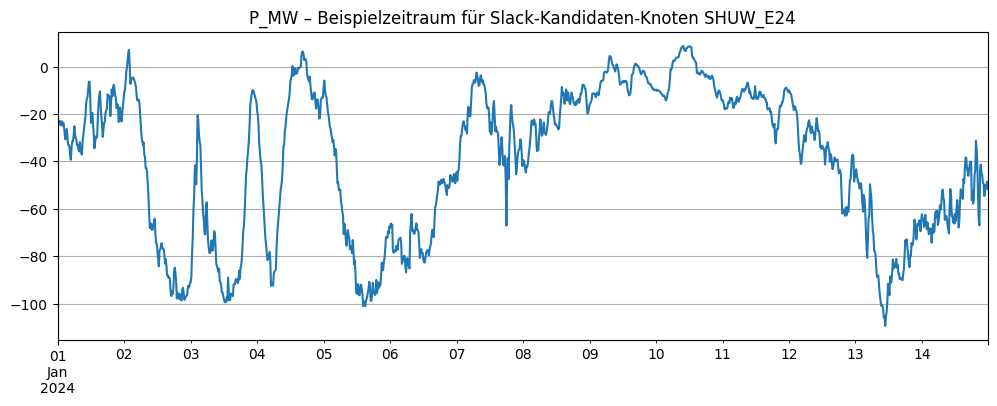

In [14]:
# ===============================================================
# Slack-Kandidaten: Knoten mit „meistem Durchsatz“
# Basis: historische Leistungswerte P_MW aus clean["measurements"]
# ===============================================================

from src.main import main
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1) Daten laden
# ---------------------------------------------------------------
res = main(run_full_pipeline=False)
clean = res["clean"]

meas = clean["measurements"]  # dict: node_id -> Series (P_MW)
print(f"Anzahl Knoten mit Messwerten: {len(meas)}")

# Zeitauflösung (15min -> 0.25 h)
HOURS_PER_STEP = 0.25  # 15 Minuten

# ---------------------------------------------------------------
# 2) Kennzahlen je Knoten berechnen
#    - mean_P_MW: mittlere Wirkleistung (kann + / - sein)
#    - max_P_MW: maximal eingespeiste Leistung
#    - min_P_MW: maximal aufgenommene Leistung
#    - mean_abs_P_MW: mittlere |P|
#    - total_abs_MWh: Summe |P| * Δt  -> "durchgesetzte Energie"
# ---------------------------------------------------------------
stats = []

for node_id, s in meas.items():
    # NaNs raus; für unseren Zweck uninteressant
    s = s.dropna()
    if s.empty:
        continue

    mean_P = s.mean()
    max_P = s.max()
    min_P = s.min()
    mean_abs_P = s.abs().mean()
    total_abs_MWh = s.abs().sum() * HOURS_PER_STEP

    stats.append(
        {
            "node": node_id,
            "mean_P_MW": mean_P,
            "max_P_MW": max_P,
            "min_P_MW": min_P,
            "mean_abs_P_MW": mean_abs_P,
            "total_abs_MWh": total_abs_MWh,
        }
    )

df_nodes = pd.DataFrame(stats).set_index("node")

# ---------------------------------------------------------------
# 3) Ranking nach "Durchsatz" (integrierte |P| in MWh)
# ---------------------------------------------------------------
df_sorted = df_nodes.sort_values("total_abs_MWh", ascending=False)

print("\n--- Top-10 Knoten nach total_abs_MWh (|P| integriert) ---")
display(df_sorted.head(10))

best_node = df_sorted.index[0]
print(f"\n→ Knoten mit größtem Durchsatz (total_abs_MWh): {best_node}")
print(df_sorted.loc[best_node])

# Optional: Wenn du dir diesen Knoten noch einmal zeitlich anschauen willst
import matplotlib.pyplot as plt

s_best = meas[best_node]

plt.figure(figsize=(12, 4))
s_best["2024-01-01":"2024-01-14"].plot()
plt.title(f"P_MW – Beispielzeitraum für Slack-Kandidaten-Knoten {best_node}")
plt.grid(True)
plt.show()


In [15]:
from src.network.network_model import load_network_model

net = load_network_model()

best_node = df_sorted.index[0]  # dein Top-Durchsatz-Knoten aus der vorherigen Auswertung

# Kandidaten-Busbar suchen: alle Kanten, die best_node berühren
adj_edges = net.lines[
    (net.lines["from_node"] == best_node) | (net.lines["to_node"] == best_node)
]

# Knoten-Tabelle (mit Spalte 'type')
nodes_df = net.nodes  # index = node_id, col 'type'

busbar_candidates = set()

for _, e in adj_edges.iterrows():
    other = e["to_node"] if e["from_node"] == best_node else e["from_node"]
    if nodes_df.loc[other, "type"] == "busbar":
        busbar_candidates.add(other)

if len(busbar_candidates) == 1:
    slack_node = list(busbar_candidates)[0]
    print(f"Slack-Knoten: Sammelschiene {slack_node} (verbunden mit {best_node})")
elif len(busbar_candidates) > 1:
    print("Mehrere Busbars angrenzend, bitte eine auswählen:", busbar_candidates)
    slack_node = best_node  # Fallback-Regel
else:
    slack_node = best_node
    print(f"Keine Busbar angrenzend – nutze direkt {best_node} als Slack.")

# slack_node kannst du dann an load_network_model(slack_node=...) übergeben


2025-12-08 15:08:39 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 15:08:39 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 15:08:39 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung JUBO_E02_JUBO (JUBO

Keine Busbar angrenzend – nutze direkt SHUW_E24 als Slack.


In [1]:
from src.utils.logging_config import setup_logging
from src.network.network_model import load_network_model

setup_logging()

net = load_network_model()   # nutzt jetzt SLACK_NODE_ID aus config

print("Slack-Knoten:", net.slack_node)
print("Nodes:", net.nodes.shape)
print("Lines:", net.lines.shape)
print("A:", net.A.shape, "Bbus:", net.Bbus.shape, "Ar:", net.Ar.shape, "B_rr:", net.B_rr.shape)


2025-12-08 15:24:29 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 15:24:29 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 15:24:29 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 15:24:29 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-1

Slack-Knoten: SHUW
Nodes: (29, 12)
Lines: (15, 11)
A: (15, 29) Bbus: (29, 29) Ar: (15, 28) B_rr: (28, 28)


## PTDF

In [1]:
from src.utils.logging_config import setup_logging
from src.network.network_model import load_network_model
from src.network.ptdf import compute_ptdf

setup_logging()

net = load_network_model()

H_rel = compute_ptdf(
    net,
    relevant_only=True,
    use_pinv=True,   # <--- wichtiger Parameter
)

print("Slack-Knoten:", net.slack_node)
print("PTDF-Shape:", H_rel.shape)
display(H_rel.head())


Slack-Knoten: SHUW
PTDF-Shape: (15, 16)


,BOLN_E01,BOLN_E02,BOLN_E03,BOLS_E41,BOLS_E42,JUBO_E01,JUBO_E02,JUBO_E03,SHUW_E23,SHUW_E24,SIES_E02,SIEV_E01,TARP_E01,TARP_E03,WEDING_E12,WEDING_E14
id,,,,,,,,,,,,,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",2.172407e-14,-0.9,4.862238e-15,0.1,-3.871519e-15,7.358538e-17,1.499263e-31,-7.585368e-30,0.1,1.348084e-15,0.1,0.1,-1.575023e-15,0.0,0.1,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",-3.678906e-13,-0.5,-1.430818e-14,-0.5,-3.612697e-14,-1.826330e-14,-2.335892e-30,1.385369e-27,-0.5,-1.989113e-14,0.5,0.5,-2.418675e-14,0.0,0.5,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",4.113445e-13,-0.3,2.395370e-14,0.7,2.802621e-14,1.749851e-14,2.635345e-30,-1.400529e-27,0.7,1.843532e-14,-0.3,-0.3,2.103942e-14,0.0,-0.3,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",1.406088e-13,-0.1,1.225696e-15,0.9,1.339597e-14,6.078661e-15,7.978004e-31,-3.781460e-28,-0.1,6.613231e-15,-0.1,-0.1,8.479234e-15,0.0,-0.1,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",1.310324e-13,-0.1,2.135084e-14,-0.1,1.291639e-15,5.438551e-15,1.039865e-30,-6.444569e-28,0.9,5.005000e-15,-0.1,-0.1,4.066276e-15,0.0,-0.1,0.0


In [1]:
from src.network.network_model import load_network_model
from src.network.ptdf import compute_ptdf_full, check_ptdf_kcl, debug_single_injection

net = load_network_model()
H_full = compute_ptdf_full(net, use_pinv=True)

# 1) KCL-Check über alle Nicht-Slack-Knoten
check_ptdf_kcl(net, H_full, sample_nodes=None, tol=1e-8)

# 2) Einzel-Injektion debuggen
flows, kcl_vec = debug_single_injection(net, H_full, node_id="SHUW_E24")
display(flows.head())
display(kcl_vec)


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

id
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN       5.932523e-16
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3    5.329150e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3   -3.932672e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS      -8.645290e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3       1.302555e-14
Name: flow_per_1MW, dtype: float64

BOLN          0.000000e+00
BOLN_A3      -8.032262e-16
BOLN_E01      0.000000e+00
BOLN_E02     -5.932523e-16
BOLN_E03      0.000000e+00
BOLS_A3      -8.312935e-15
BOLS_A5      -1.666667e-01
BOLS_E41     -8.645290e-15
BOLS_E42     -1.666667e-01
JUBO          0.000000e+00
JUBO_A5      -1.666667e-01
JUBO_E01     -1.666667e-01
JUBO_E02      0.000000e+00
JUBO_E03      0.000000e+00
SHUW_E23      1.302555e-14
SHUW_E24      8.333333e-01
SIES          0.000000e+00
SIES_A3       1.317594e-15
SIES_E02      2.545127e-17
SIEV          0.000000e+00
SIEV_A3       5.554123e-15
SIEV_E01      4.476351e-15
TARP          0.000000e+00
TARP_E01     -1.666667e-01
TARP_E03      0.000000e+00
WEDING        0.000000e+00
WEDING_E12   -6.044368e-15
WEDING_E14    0.000000e+00
Name: kcl_balance, dtype: float64

### flows

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from src.network.network_model import load_network_model
from src.network.ptdf import compute_ptdf

# Netzmodell laden (Slack kommt aus config.py)
net = load_network_model()

# PTDF für relevante Knoten berechnen (uw_field + battery)
H_rel = compute_ptdf(net, relevant_only=True)

# Knoten, für die wir Zeitreihen benötigen
relevant_nodes = list(H_rel.columns)

print("Relevante Knoten:", relevant_nodes)
print("Shape H_rel:", H_rel.shape)

# --------------------------------------------------
# Pfad zu den Zeitreihen & Spaltennamen
# --------------------------------------------------
MEAS_DIR = Path("src/data/raw/timeseries")  # ggf. anpassen

# Spaltennamen in den CSV-Dateien anpassen, falls nötig
TS_COL  = "timestamp"       # Zeitstempel-Spalte
VAL_COL = "P_MW"  # Leistungs-Spalte (z.B. in MW)

print(f"MEAS_DIR: {MEAS_DIR}")
if not MEAS_DIR.exists():
    raise FileNotFoundError(f"MEAS_DIR existiert nicht: {MEAS_DIR}")

all_csv = sorted(p.name for p in MEAS_DIR.glob("*.csv"))
print(f"Gefundene CSV-Dateien: {len(all_csv)}")
for name in all_csv:
    print("-", name)


# --------------------------------------------------
# Loader: lädt <node>.csv oder <node>_hist.csv
# --------------------------------------------------
def load_series(node_id: str) -> pd.Series | None:
    """
    Lädt die Zeitreihe für einen Knoten aus
        <MEAS_DIR>/<node_id>.csv  oder
        <MEAS_DIR>/<node_id>_hist.csv

    Erwartet eine Zeitspalte TS_COL und eine Wertspalte VAL_COL.
    """
    candidates = [
        MEAS_DIR / f"{node_id}.csv",
        MEAS_DIR / f"{node_id}_hist.csv",
    ]

    path = None
    for c in candidates:
        if c.exists():
            path = c
            break

    if path is None:
        print(f"[MISS] Keine Datei für Node {node_id} gefunden (weder *.csv noch *_hist.csv).")
        return None

    df = pd.read_csv(path)
    print(f"[LOAD] {node_id}: {path.name} | Spalten = {list(df.columns)}")

    if TS_COL not in df.columns or VAL_COL not in df.columns:
        print(f"[SKIP] {path.name} hat nicht TS_COL={TS_COL} und VAL_COL={VAL_COL}.")
        return None

    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce", utc=True)
    df = df.dropna(subset=[TS_COL, VAL_COL])
    if df.empty:
        print(f"[EMPTY] {path.name} hat nach Cleaning keine gültigen Zeilen.")
        return None

    s = (
        df.set_index(TS_COL)[VAL_COL]
        .astype(float)
        .tz_convert(None)
        .sort_index()
    )
    print(f"[OK]   {node_id}: {len(s)} Punkte.")
    return s


# --------------------------------------------------
# Zeitreihen für relevante Knoten laden
# --------------------------------------------------
# Annahme: relevant_nodes kommt z.B. aus H_rel.columns
try:
    relevant_nodes = list(H_rel.columns)
except NameError:
    raise RuntimeError("relevant_nodes ist nicht definiert – typischerweise: relevant_nodes = list(H_rel.columns)")

series_dict: dict[str, pd.Series] = {}

print("\n--- Lade Zeitreihen für relevante Knoten ---")
for nid in relevant_nodes:
    s = load_series(nid)
    if s is None or s.empty:
        continue
    series_dict[nid] = s

print("\n--- Zusammenfassung ---")
print(f"Knoten mit vorhandener Zeitreihe: {len(series_dict)}")
print("Nodes:", sorted(series_dict.keys()))

if not series_dict:
    raise RuntimeError(
        "Keine Zeitreihen für relevante Knoten geladen. "
        "Prüfe MEAS_DIR, Dateinamen und Spaltennamen (TS_COL/VAL_COL)."
    )

# --------------------------------------------------
# Gemeinsame Zeitbasis (inner join)
# --------------------------------------------------
df_P = pd.concat(series_dict.values(), axis=1, join="inner")
df_P.columns = list(series_dict.keys())

print("\n---- Zeitreihen-Matrix df_P ----")
print("Gemeinsame Zeitpunkte:", len(df_P))
print("Knoten mit Messwerten:", df_P.shape[1])
display(df_P.head())


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

Relevante Knoten: ['BOLN_E01', 'BOLN_E02', 'BOLN_E03', 'BOLS_E41', 'BOLS_E42', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'SHUW_E23', 'SHUW_E24', 'SIES_E02', 'SIEV_E01', 'TARP_E01', 'TARP_E03', 'WEDING_E12', 'WEDING_E14']
Shape H_rel: (15, 16)
MEAS_DIR: src/data/raw/timeseries
Gefundene CSV-Dateien: 15
- BOLN_E01_hist.csv
- BOLN_E02_hist.csv
- BOLN_E03_hist.csv
- BOLS_E41_hist.csv
- BOLS_E42_hist.csv
- JUBO_E02_hist.csv
- JUBO_E03_hist.csv
- SHUW_E23_hist.csv
- SHUW_E24_hist.csv
- SIES_E02_hist.csv
- SIEV_E01_hist.csv
- Tarp_E01_hist.csv
- Tarp_E03_hist.csv
- Weding_E12_hist.csv
- Weding_E14_hist.csv

--- Lade Zeitreihen für relevante Knoten ---
[LOAD] BOLN_E01: BOLN_E01_hist.csv | Spalten = ['timestamp', 'P_MW', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
[OK]   BOLN_E01: 65476 Punkte.
[LOAD] BOLN_E02: BOLN_E02_hist.csv | Spalten = ['timestamp', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
[SKIP] BOLN_E02_hist.csv hat nicht TS_COL=timestamp und VAL_COL=P_MW.
[LOAD]

,BOLN_E01,BOLN_E03,BOLS_E41,BOLS_E42,JUBO_E02,JUBO_E03,SHUW_E23,SHUW_E24,SIES_E02,SIEV_E01,TARP_E01,TARP_E03,WEDING_E12,WEDING_E14
timestamp,,,,,,,,,,,,,,
2025-07-02 15:30:00,-1.060031,-2.760247,-0.049500,0.311850,-5.738144,-10.248208,-29.517407,-35.888707,-1.325459,-24.168873,20.000000,4.333333,-0.991650,-4.816350
2025-07-02 15:45:00,-3.034188,-8.116977,-0.049500,4.865847,-18.515167,-16.038347,-32.450693,-56.824393,-2.999312,-23.523267,18.266667,10.666667,-6.948147,-11.421297
2025-07-02 16:00:00,-6.074335,-18.029455,-41.334133,-5.888849,-30.232387,-14.651100,-11.311915,-62.848493,-5.405685,-27.280027,23.200000,17.066667,-4.796550,-17.250740
2025-07-02 16:15:00,-5.970118,-18.928687,-46.426060,-6.071170,-18.431800,-9.688532,-4.489510,-42.408253,-5.093024,-16.857033,21.000000,4.533333,3.598650,-4.775100
2025-07-02 16:30:00,-2.161747,-8.441539,-46.861627,18.003157,-8.771635,-6.663969,11.121135,-44.953487,-2.117162,-9.165937,11.600000,3.600000,13.472237,-3.870907


In [2]:
from pathlib import Path
from src.network.network_model import load_network_model
from src.network.flows import build_flows_timeseries

net = load_network_model()  # nutzt Slack aus config.py
meas_dir = Path("src/data/raw/timeseries")

df_F, H_rel, df_P = build_flows_timeseries(
    net=net,
    meas_dir=meas_dir,
    relevant_only=True,   # nur uw_field + battery
    use_pinv=False,       # oder True, wenn du magst
)

df_F.head()


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

id,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",110-TARP-WEDI-GRUEN TARP-WEDI,110_SHUW_TARP_GELB_JUBO_BOLS_A5_BOLS,110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,110_SHUW_TARP_GELB_JUBO_JUBO_A5_BOLS_A5,110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5
timestamp,,,,,,,,,,,,,,,
2025-07-02 15:30:00,-5.605289,1.540462,-12.751040,5.555789,-23.912118,-4.279830,8.344657,18.563584,4.613639,4.574842,-2.907993,22.596143,-28.100278,2.596143,33.292564
2025-07-02 15:45:00,-6.597092,-0.485266,-12.708918,6.547592,-25.853601,-3.597780,10.680138,16.926175,-0.351055,11.043982,-10.481161,23.881980,-39.978454,5.615313,51.209080
2025-07-02 16:00:00,-9.012831,7.581893,-25.607555,-32.321302,-2.299084,-3.607146,5.038083,18.267196,4.216281,17.158703,-1.700708,30.789557,-40.079822,7.589557,55.258936
2025-07-02 16:15:00,-6.926698,16.282081,-30.135477,-39.499362,2.437188,-1.833674,-7.521710,9.930336,10.525348,4.654217,1.491266,25.579904,-28.668542,4.579904,37.828349
2025-07-02 16:30:00,-3.355135,18.964814,-25.675085,-43.506491,14.476271,-1.237973,-14.371706,5.810802,16.827372,3.735453,-20.561545,14.158388,-37.278322,2.558388,42.395098


In [2]:
import os
import pandas as pd
import numpy as np

# Pfad zum Timeseries-Ordner
MEAS_DIR = r"src/data/raw/timeseries"

TS_COL = "timestamp"
VAL_COL = "P_MW"

# -----------------------------
# 1) Batterie laden
# -----------------------------
bess_file = "BOLS_E42_hist.csv"   # oder z.B. "BOLS_A5_hist.csv"
bess_path = os.path.join(MEAS_DIR, bess_file)

bess = pd.read_csv(bess_path, parse_dates=[TS_COL])
bess = bess[[TS_COL, VAL_COL]].rename(columns={VAL_COL: "BESS_P"})
bess = bess.sort_values(TS_COL).set_index(TS_COL)


# -----------------------------
# 2) Alle anderen Nodes laden
# -----------------------------
correlations = {}

for fname in os.listdir(MEAS_DIR):
    if not fname.endswith("_hist.csv"):
        continue
    if fname == bess_file:
        continue

    path = os.path.join(MEAS_DIR, fname)
    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # gemeinsame Zeitbasis finden
    merged = bess.join(df, how="inner", rsuffix="_other")

    if len(merged) < 100:   # zu wenige Samples, überspringen
        continue

    corr = merged["BESS_P"].corr(merged[VAL_COL])
    correlations[fname.replace("_hist.csv", "")] = corr


# -----------------------------
# 3) Sortiert ausgeben
# -----------------------------
s = pd.Series(correlations).sort_values(key=np.abs, ascending=False)
print("Korrelation zwischen Batterie-P und allen anderen Knoten:")
print(s)


Korrelation zwischen Batterie-P und allen anderen Knoten:
BOLS_E41      0.940766
TARP_E01     -0.447962
SHUW_E23     -0.440713
WEDING_E12   -0.430709
WEDING_E14   -0.320049
SHUW_E24     -0.318354
TARP_E03      0.316852
SIEV_E01      0.255469
JUBO_E03      0.232275
JUBO_E01     -0.145870
JUBO_E02      0.069637
SIES_E02      0.049523
BOLN_E03     -0.049197
BOLN_E02      0.048678
BOLN_E01     -0.016657
dtype: float64


BESS-Zeitreihe geladen: BOLS_E42_hist.csv, Samples: 68112
Korrelationen VOR Bereinigung (BESS_P vs. Node):
BOLS_E41      0.940766
TARP_E01     -0.447962
SHUW_E23     -0.440713
WEDING_E12   -0.430709
WEDING_E14   -0.320049
SHUW_E24     -0.318354
TARP_E03      0.316852
SIEV_E01      0.255469
JUBO_E03      0.232275
JUBO_E01     -0.145870
JUBO_E02      0.069637
SIES_E02      0.049523
BOLN_E03     -0.049197
BOLN_E02      0.048678
BOLN_E01     -0.016657
dtype: float64

Zusammenfassung Regression & Bereinigung:
      node  corr_before    corr_after      beta      alpha       r2  mean_abs_removed_MW  is_bess_uw_field
  BOLS_E41     0.940766  9.247196e-04  0.942776  -0.048351 0.885040            13.090777              True
  TARP_E01    -0.447962 -1.442284e-04 -0.367999  20.028707 0.796828             5.109797             False
  SHUW_E23    -0.440713 -2.745527e-04 -0.505464 -27.813207 0.751213             7.018543             False
WEDING_E12    -0.430709 -2.116053e-03 -0.273330   5.094285 0.1

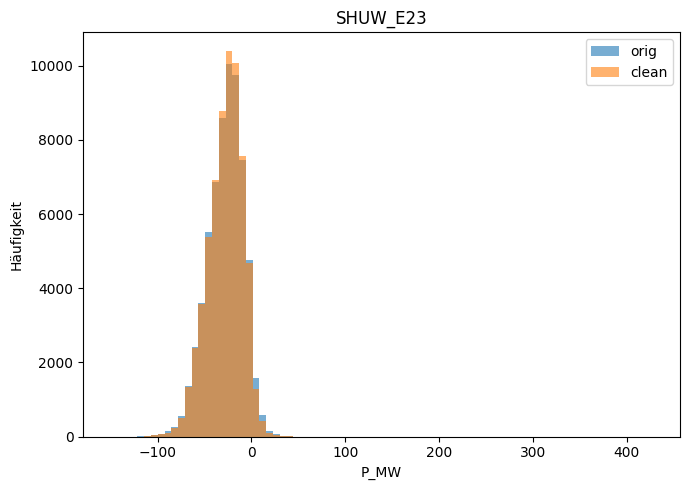

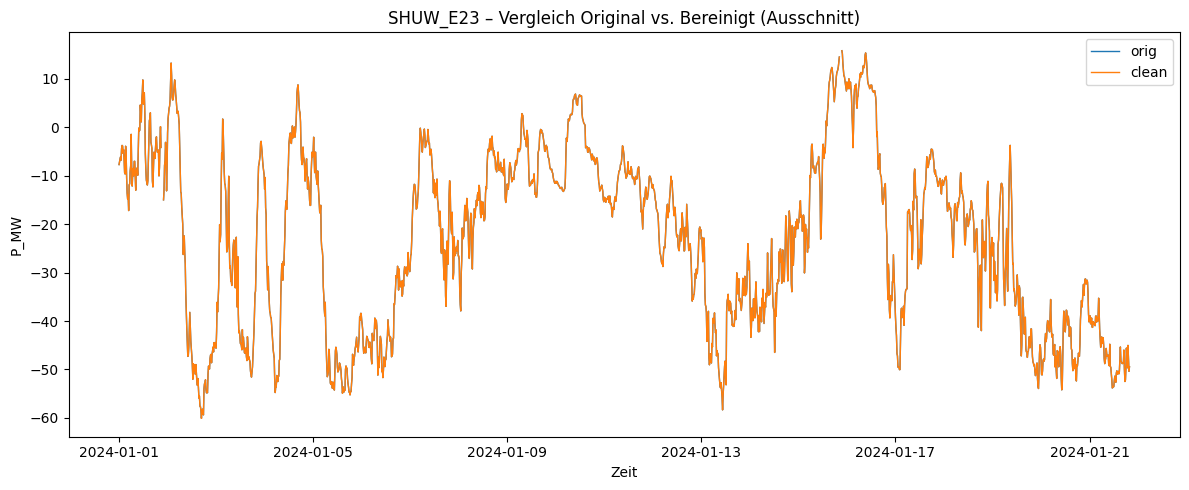

In [10]:
# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# KONFIGURATION
# ============================

MEAS_DIR = r"src/data/raw/timeseries"
TS_COL = "timestamp"
VAL_COL = "P_MW"

# Datei mit BESS-Leistung
BESS_FILE = "BOLS_E42_hist.csv"

# >>> HIER SELBST PFLEGEN <<<
# Namen (ohne _hist.csv) der UW-Felder direkt am BESS-Umspannwerk
BESS_UW_FIELDS = [
    "BOLS_E41",
    "BOLS_E42",   # BESS selbst
    # "BOLS_E43",
]

# Node für Beispielplots
PLOT_NODE = "SHUW_E23"   # kannst du anpassen

# %%
# ============================
# 1) BESS laden
# ============================

bess_path = os.path.join(MEAS_DIR, BESS_FILE)

bess = pd.read_csv(bess_path, parse_dates=[TS_COL])
bess = bess[[TS_COL, VAL_COL]].rename(columns={VAL_COL: "BESS_P"})
bess = bess.sort_values(TS_COL).set_index(TS_COL)

print(f"BESS-Zeitreihe geladen: {BESS_FILE}, Samples: {len(bess)}")

# %%
# ============================
# 2) Hilfsfunktion: lineare Regression
#    y ≈ alpha + beta * x
# ============================

def fit_simple_linear_regression(x: pd.Series, y: pd.Series):
    """
    Einfache OLS-Regression:
        y ≈ alpha + beta * x

    Rückgabe:
      alpha, beta, r2
    """
    x = x.astype(float)
    y = y.astype(float)

    mx = x.mean()
    my = y.mean()

    cov_xy = ((x - mx) * (y - my)).sum()
    var_x = ((x - mx) ** 2).sum()

    if var_x == 0:
        beta = 0.0
    else:
        beta = cov_xy / var_x

    alpha = my - beta * mx

    # R^2
    y_hat = alpha + beta * x
    ss_res = ((y - y_hat) ** 2).sum()
    ss_tot = ((y - my) ** 2).sum()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return alpha, beta, r2

# %%
# ============================
# 3) Korrelationen VOR Bereinigung
# ============================

correlations_before = {}
orig_series = {}   # komplette Original-Serien pro Node (eigener Index)

for fname in os.listdir(MEAS_DIR):
    if not fname.endswith("_hist.csv"):
        continue
    if fname == BESS_FILE:
        continue  # BESS selbst überspringen

    node_name = fname.replace("_hist.csv", "")
    path = os.path.join(MEAS_DIR, fname)

    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # Original-Zeitreihe (voll) merken
    orig_series[node_name] = df[VAL_COL]

    # Für Korrelation nur gemeinsame Zeitbasis mit BESS
    merged = bess.join(df, how="inner", rsuffix="_other")
    if len(merged) < 100:
        continue

    corr_before = merged["BESS_P"].corr(merged[VAL_COL])
    correlations_before[node_name] = corr_before

print("Korrelationen VOR Bereinigung (BESS_P vs. Node):")
s_before = pd.Series(correlations_before).sort_values(key=np.abs, ascending=False)
print(s_before)

# %%
# ============================
# 4) Regression + Bereinigung auf voller Node-Zeitreihe
#    P_node_clean(t) = P_node(t) - beta * P_BESS(t)
#    BESS-Werte, die fehlen -> 0  (dort keine Korrektur)
# ============================

results = []
clean_series = {}

for node_name, corr_before in correlations_before.items():
    fname = f"{node_name}_hist.csv"
    path = os.path.join(MEAS_DIR, fname)

    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # 1) Für REGRESSION: nur Schnittmenge Node & BESS
    merged = bess.join(df, how="inner", rsuffix="_other")
    if len(merged) < 100:
        continue

    x_reg = merged["BESS_P"]
    y_reg = merged[VAL_COL]

    alpha, beta, r2 = fit_simple_linear_regression(x_reg, y_reg)

    # 2) Für BEREINIGUNG: auf voller Node-Zeitreihe arbeiten
    #    BESS auf Node-Index legen (Roh-Version mit NaNs)
    bess_on_node_idx_raw = bess.reindex(df.index)["BESS_P"]
    # Version mit NaN->0 für die tatsächliche Korrektur
    bess_on_node_idx = bess_on_node_idx_raw.fillna(0.0)

    y_full = df[VAL_COL]
    y_clean_full = y_full - beta * bess_on_node_idx

    # 3) Korrelation NACH Bereinigung: nur auf Zeiten mit BESS-Wert
    mask = ~bess_on_node_idx_raw.isna()
    if mask.sum() >= 10:
        corr_after = bess_on_node_idx_raw[mask].corr(y_clean_full[mask])
    else:
        corr_after = np.nan

    # mittlere entfernte Leistung (nur dort, wo BESS Daten hat, also x_reg)
    mean_abs_removed = (beta * x_reg).abs().mean()

    clean_series[node_name] = y_clean_full

    is_bess_uw = node_name in BESS_UW_FIELDS

    results.append({
        "node": node_name,
        "corr_before": corr_before,
        "corr_after": corr_after,
        "beta": beta,
        "alpha": alpha,
        "r2": r2,
        "mean_abs_removed_MW": mean_abs_removed,
        "is_bess_uw_field": is_bess_uw,
    })

# %%
# ============================
# 5) Ergebnis-Tabelle
# ============================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="corr_before", key=np.abs, ascending=False)

print("\nZusammenfassung Regression & Bereinigung:")
print(results_df.to_string(index=False))

# %%
# ============================
# 6) DataFrames mit Original & Bereinigt
# ============================

orig_df = pd.DataFrame(orig_series)
clean_df = pd.DataFrame(clean_series)

# Korrelationen vor/nach: jeweils nur auf Schnitt mit BESS
corr_before_full = (
    orig_df.join(bess, how="inner")
           .corr()["BESS_P"]
           .drop("BESS_P")
)

corr_after_full = (
    clean_df.join(bess, how="inner")
            .corr()["BESS_P"]
            .drop("BESS_P")
)

print("\nKorrelationsvergleich (BESS_P vs. Nodes):")
corr_compare = pd.DataFrame({
    "corr_before": corr_before_full,
    "corr_after": corr_after_full
}).sort_values(by="corr_before", key=np.abs, ascending=False)

print(corr_compare)

# %%
# ============================
# 7) Beispiel-Statistiken für einen Node
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    print(f"\nDescriptive Stats für {PLOT_NODE} (ORIG):")
    print(orig_df[PLOT_NODE].describe())
    print(f"\nDescriptive Stats für {PLOT_NODE} (CLEAN):")
    print(clean_df[PLOT_NODE].describe())
else:
    print(f"\nWARNUNG: {PLOT_NODE} nicht in Daten gefunden.")

# %%
# ============================
# 8) Histogramm-Vergleich für einen Node
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    plt.figure(figsize=(7, 5))
    plt.hist(orig_df[PLOT_NODE].dropna(), bins=80, alpha=0.6, label="orig")
    plt.hist(clean_df[PLOT_NODE].dropna(), bins=80, alpha=0.6, label="clean")
    plt.title(PLOT_NODE)
    plt.xlabel("P_MW")
    plt.ylabel("Häufigkeit")
    plt.legend()
    plt.tight_layout()
    plt.show()

# %%
# ============================
# 9) Zeitreihen-Vergleich (Ausschnitt)
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    # irgendein Zeitraum wählen (z.B. erste 2000 Punkte)
    slice_idx = orig_df.index[:2000]

    plt.figure(figsize=(12, 5))
    plt.plot(slice_idx, orig_df.loc[slice_idx, PLOT_NODE], label="orig", linewidth=1)
    plt.plot(slice_idx, clean_df.loc[slice_idx, PLOT_NODE], label="clean", linewidth=1)
    plt.title(f"{PLOT_NODE} – Vergleich Original vs. Bereinigt (Ausschnitt)")
    plt.xlabel("Zeit")
    plt.ylabel("P_MW")
    plt.legend()
    plt.tight_layout()
    plt.show()


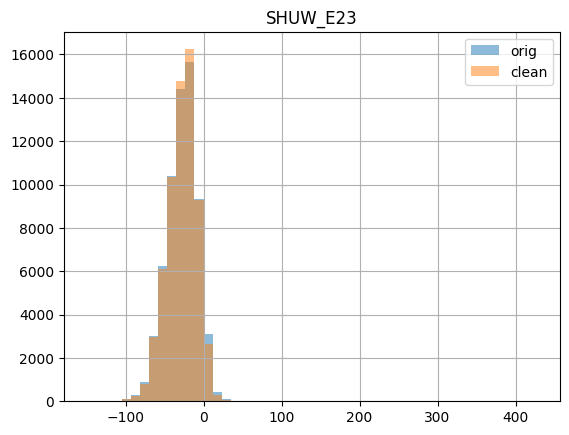

In [11]:
import matplotlib.pyplot as plt

node = "SHUW_E23"
orig_df[node].hist(bins=50, alpha=0.5, label="orig")
clean_df[node].hist(bins=50, alpha=0.5, label="clean")
plt.legend()
plt.title(node)
plt.show()


In [13]:
clean_df["SHUW_E23"].describe()

count    63934.000000
mean       -27.574874
std         18.552395
min       -150.303600
25%        -39.422347
50%        -25.543960
75%        -14.453785
max        427.740991
Name: SHUW_E23, dtype: float64

In [12]:
orig_df["SHUW_E23"].describe()

count    63934.000000
mean       -27.500240
std         19.113640
min       -150.303600
25%        -39.809013
50%        -25.598310
75%        -14.061473
max        427.740991
Name: SHUW_E23, dtype: float64